# <font>Exploring the data and hyperparameter selection</font>

Research questions to ask:

1. What regions of the brain are associated with playing Rock-Paper-Scissors well?

2. Do the voxel coordinates have any effect on performance in the Rock-Paper-Scissors game?



In [154]:
import bdpy
import torch
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets  # interactive display
import matplotlib.pyplot as plt

from PIL import Image
from random import seed
from bdpy.util import get_refdata

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier

import visbrain 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [155]:
%matplotlib inline

In [156]:
sns.set_theme(style="whitegrid")

### I. Explore the data

In [157]:
def show_metadata(the_filename):
    voxel_data = bdpy.BData(the_filename)
    print(voxel_data.show_metadata())

In [168]:
regions_of_interest = {
        'CB_LHand' : 'VOX_CB_LHand = 1',
        'CB_RHand' : 'VOX_CB_RHand = 1',
        'M1_LHand' : 'VOX_M1_LHand = 1',
        'M1_RHand' : 'VOX_M1_RHand = 1',
        'SMA_LHand': 'VOX_SMA_LHand = 1',
        'SMA_RHand': 'VOX_SMA_RHand = 1',
    }

def extract_data(roi):
    data = bdpy.BData('data/S1.h5')
    
    voxel_data = data.select(regions_of_interest[roi])
    data_type = data.select('VoxelData')
    data_labels = data.select('Label')
    
    # convert labels from floats to ints
    data_labels = np.floor(data_labels).astype(int)
    
    return voxel_data, data_labels

In [159]:
show_metadata('data/S1.h5')
#show_metadata('data/data.h5')

| Key           | Description           |
|---------------|-----------------------|
| VoxelData     | 1 = voxel data        |
| Run           | 1 = run number        |
| Block         | 1 = block number      |
| Label         | 1 = labels            |
| voxel_x       | Voxel x coordinate    |
| voxel_y       | Voxel y coordinate    |
| voxel_z       | Voxel z coordinate    |
| VOX_CB_LHand  | 1 = ROI VOX_CB_LHand  |
| VOX_CB_RHand  | 1 = ROI VOX_CB_RHand  |
| VOX_M1_LHand  | 1 = ROI VOX_M1_LHand  |
| VOX_M1_RHand  | 1 = ROI VOX_M1_RHand  |
| VOX_SMA_LHand | 1 = ROI VOX_SMA_LHand |
| VOX_SMA_RHand | 1 = ROI VOX_SMA_RHand |
| CB            | ROI flag for CB       |
| M1            | ROI flag for M1       |
| SMA           | ROI flag for SMA      |
None


### 2. Choose the best model

We'll do cross validation while training the model.

Create the pipelines for various models (at the same time, also creating the models).

In [160]:
pipeline_lr = Pipeline([('LR', LogisticRegression(multi_class='multinomial', random_state=42))])
pipeline_svc = Pipeline([('SVC', SVC(random_state=42))])
pipeline_knn = Pipeline([('KNN', KNeighborsClassifier())])
pipeline_dt = Pipeline([('DT',DecisionTreeClassifier(random_state=42))])
pipeline_rf = Pipeline([('RF',RandomForestClassifier(random_state=42))])
#pipeline_xgb = Pipeline([('XGB', XGBClassifier(random_state=42))])

Initialize hyperparameters or certain weights for each estimator. Put the parameters in grids for model.

In [173]:
# inverse of regularization; smaller values specify stronger regularization
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

lr_param_grid = [{'LR__penalty': ['l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['lbfgs']}]


svc_param_grid = [{'SVC__kernel': ['linear', 'rbf'], 
                    'SVC__C': param_range}]

knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]

#xgb_param_grid = [{'XGB__learning_rate': learning_rates,
#                    'XGB__max_depth': param_range,
#                    'XGB__min_child_weight': param_range[:2],
#                    'XGB__subsample': param_range_fl,
#                    'XGB__n_estimators': n_estimators}]

In [174]:
nfolds = 5
lr_grid_search = GridSearchCV(estimator=pipeline_lr,
                              param_grid=lr_param_grid,
                              scoring='accuracy',
                              cv=nfolds)

svc_grid_search = GridSearchCV(estimator=pipeline_svc,
                               param_grid=svc_param_grid,
                               scoring='accuracy',
                               cv=nfolds)

knn_grid_search = GridSearchCV(estimator=pipeline_knn,
                               param_grid=knn_param_grid,
                               scoring='accuracy',
                               cv=nfolds)


dt_grid_search = GridSearchCV(estimator=pipeline_dt,
                              param_grid=dt_param_grid,
                              scoring='accuracy',
                              cv=nfolds)

rf_grid_search = GridSearchCV(estimator=pipeline_rf,
                              param_grid=rf_param_grid,
                              scoring='accuracy',
                              cv=nfolds)

#xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
#                               param_grid=xgb_param_grid,
#                               scoring='accuracy',
#                               cv=nfolds)

Create a list of the grids. And run the pipeline.

In [175]:
grids = [lr_grid_search, svc_grid_search, knn_grid_search, dt_grid_search]
#, rf_grid_search]
#, xgb_grid_search]

In [176]:
print(grids)

[GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('LR',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=42))]),
             param_grid=[{'LR__C': [1.0, 0.5, 0.1], 'LR__penalty': ['l2'],
                          'LR__solver': ['lbfgs']}],
             scoring='accuracy'), GridSearchCV(cv=5, estimator=Pipeline(steps=[('SVC', SVC(random_state=42))]),
             param_grid=[{'SVC__C': [1, 2, 3, 4, 5, 6],
                          'SVC__kernel': ['linear', 'rbf']}],
             scoring='accuracy'), GridSearchCV(cv=5, estimator=Pipeline(steps=[('KNN', KNeighborsClassifier())]),
             param_grid=[{'KNN__metric': ['euclidean', 'manhattan'],
                          'KNN__n_neighbors': [1, 2, 3, 4, 5, 6],
                          'KNN__weights': ['uniform', 'distance']}],
             scoring='accuracy'), GridSearchCV(cv=5,
             estimator=Pipeline(steps=[

Now find the best estimator with the best parameters.

In [165]:
regions_of_interest = ['CB_LHand', 'CB_RHand', 'M1_LHand', 'M1_RHand', 'SMA_LHand', 'SMA_RHand']

In [166]:
def determine_scores():
    return scores

In [177]:
#accuracies = pd.DataFrame(index=regions_of_interest, columns=['Logistic Regression', 'Support Vector Machines', 'K-Nearest Neighors'])
#accuracy = pd.DataFrame(index=regions_of_interest, columns=['accuracy'])
all_the_scores = []

for roi in regions_of_interest:
    X,y = extract_data(roi)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=42)
    for pipeline in grids:
        pipeline.fit(X_train, y_train.squeeze())
        
    grid_dict = {0: 'Logistic Regression', 
                 1: 'Support Vector Machines',
                 2: 'K-Nearest Neighors',
                 3: 'Decision Tree'}
    scores = []
    
    for i, model in enumerate(grids):
        scores.append(model.score(X_test, y_test))
        
        #print('{} Test Accuracy: {}'.format(grid_dict[i],model.score(X_test,y_test)))
        print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
        #print(grid_dict[i])
        #accuracies[grid_dict[i]] = model.score(X_test, y_test)
        
        #a_series = pd.Series(scores,index=None)
        #print(a_series)
    all_the_scores.append(scores)
        #accuracies.append(a_series, ignore_index=True)

all_the_scores = np.array(all_the_scores)
accuracies = pd.DataFrame(all_the_scores, 
                          index=regions_of_interest,
                          columns=['Logistic Regression', 'Support Vector Machines', 'K-Nearest Neighors', 'Decision Tree'])

Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'lbfgs'}
Support Vector Machines Best Params: {'SVC__C': 1, 'SVC__kernel': 'linear'}
K-Nearest Neighors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 6, 'KNN__weights': 'uniform'}
Decision Tree Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 2, 'DT__min_samples_leaf': 5, 'DT__min_samples_split': 2}
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'lbfgs'}
Support Vector Machines Best Params: {'SVC__C': 1, 'SVC__kernel': 'linear'}
K-Nearest Neighors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 2, 'KNN__weights': 'uniform'}
Decision Tree Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 3, 'DT__min_samples_leaf': 6, 'DT__min_samples_split': 2}
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'lbfgs'}
Support Vector Machines Best Params: {'SVC__C': 1, 'SVC__kernel': 'linear'}
K-Nearest Neighors

In [178]:
accuracies

,Logistic Regression,Support Vector Machines,K-Nearest Neighors,Decision Tree
CB_LHand,0.65,0.65,0.50,0.40
CB_RHand,0.60,0.55,0.45,0.35
M1_LHand,0.70,0.65,0.40,0.35
M1_RHand,0.95,0.95,0.70,0.50
SMA_LHand,0.60,0.30,0.40,0.60
SMA_RHand,0.60,0.30,0.40,0.60


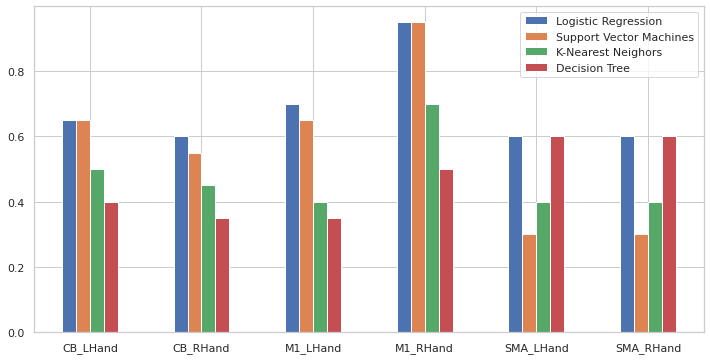

In [179]:
ax = accuracies.plot(kind="bar", figsize=(12,6), rot=0)

Linear and nonlinear methods were applied to fMRI data of one subject. 
We explored 3 regions: CB, M1 and SMA. 
We compared $4$ methods on task-based (Rock-Paper-Scissors) fMRI data:

1. logistic regression, multinomial classification with l2 penalty, risk of overfitting is high with logistic regression so we use SVM to check out whether the model is good or bad.

2. support vector (machine) classifier, overfitting is less in SVM

3. k-nearest neighbours. Linear models cannot fully describe the brain. As we learned in the past few days the brain is a complex, nonlinear system. Add to functional understanding of the brain.

4. decision tree.

What is the problem we want to solve?

Which regions of the brain react or stay silent doing some hand movements?

How do we solve the problem?
We study fMRI, functional magnetic resonance images, which are high dimension volumetric imaging scans. 

Prevent overfitting by doing cross validation. We use GridSearchCV to fine tune the hyperparameters of our models. For example in logistic regression we use l2 regularization with an lbgs solver that is good for multinomial classification. So with GridSearchCV we specify a grid of possible parameters and search for the best combination of these.
Decoding accuracy was computed separately for different motor areas of the brain.

What is the outcome?

Data were collected from regions of the brain that were activated during the RPS task. Our analysis showed that the M1_RHand is triggered, which is the region of the brain associated with hand motor . 

Technical interpretation: the linear models perform much better than the nonlinear one because we're dealing linear data, i.e., voxel data.

Biological interpretation: For complex movement (rock???) when the right hand is involved, M1 is active. The 
different hand movements were correctly classified from fMRI in the M1 using the right hand with linear methods. Predicted classes were classified from either the left or right hemisphere of the three regions.

Conclusion:

What we were hoping to learn? Biological interpretation of ML methods.

What we learned? Learned about the functions of different parts of the brain.




### References
[GridSearch + Pipelines of Multiple models on Multiclass Classification
](https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3)